<h1> Summary </h1>
Numerous studies highlight the presence of long-term momentum and short-term reversion in asset returns. This analysis aims to explore strategies based on these phenomena while addressing the following points:
<br>
<br>
<b> Long Term Momentum & Short Term Reversion </b>
    <li> Identify uncorrelated long-term momentum and short-term reversion factors </li>
    <li> Develop methods to combine these factors to maximize portfolio PnL </li>
<br>
<b> Exponential Weighted Moving Average(EWM) & Relative Strength Index(RSI) </b>
    <li> Construct a notional balanced long-short portfolio ranked by EWM and RSI </li>
    <li> Determine the optimal EWM and RSI windows to maximize PnL </li>


<br>
The analysis shows that momentum factors have performed well from the onset of the COVID-19 pandemic in 2021 to the present. This trend is exemplified by stocks like NVIDIA, which have driven overall market performance with strong momentum. Further analysis on the following points could enhance PnL:
<li> How long do momentum factors persist, and how quickly do they decay? </li>
<li> What impact do high-momentum stocks have on other stocks, and can we systematically uncover inter-stock relationships? <b> [In Progress by exploring Graph ML methods] </b> </li>



<h1> 0. Preprocessing </h1>

<h3> Get Ticker </h3>

In [25]:
next_url_exists = True
ticker_df_arr = []
as_of_date = '2024-03-24'

#Loop by exchange
for exchange in ['XNYS','XNAS']:
    for active in ["true",'false']:
        url = f"https://api.polygon.io/v3/reference/tickers?market=stocks&exchange={exchange}&date={as_of_date}&active={active}&limit=1000&apiKey={api_key}"    
        while next_url_exists:    
            response = requests.get(url)
            data = response.json()
            df = pd.DataFrame(data['results'])
            ticker_df_arr.append(df)

            if "next_url" in data.keys():
                url = data["next_url"]+f"&apiKey={api_key}"
                print("repeating...")
            else:
                break

ticker_df = pd.concat(ticker_df_arr)        

repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...
repeating...


In [26]:
#remove duplicates
ticker_df['last_updated_utc'] = pd.to_datetime(ticker_df['last_updated_utc'])
ticker_df = ticker_df.sort_values('last_updated_utc').groupby('ticker').tail(1).sort_values('ticker')

<h3> Pull 5-year historical data </h3>

In [7]:
start_date = "2019-04-01"
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')
business_dates = pd.date_range(start=start_date, end=end_date, freq='B').strftime('%Y-%m-%d').tolist()

df_arr = []

for business_date in business_dates:
    sys.stdout.write("\r"+business_date)
    url = f"https://api.polygon.io/v2/aggs/grouped/locale/us/market/stocks/{business_date}?adjusted=true&apiKey={api_key}"
    response = requests.get(url)
    data = response.json()
    if 'results' in data.keys():
        df = pd.DataFrame(data['results'])
        df['Date'] = pd.to_datetime(df['t'], unit='ms')
        df_arr.append(df)

df = pd.concat(df_arr)

2024-03-22

In [30]:
df = pd.concat(df_arr)

In [31]:
#restrict the universe to Nasdaq / NYSE tickers
raw_df = ticker_df.merge(df, how='left', left_on='ticker', right_on='T')
raw_df.to_csv('Polygon_RawData_20190401_20240322.csv', index = False)
#raw_df = raw_df.rename(columns={'datetime':'Date'})

In [5]:
#data_df = raw_df.copy()
data_df = pd.read_csv('Polygon_RawData_20190401_20240322.csv')
data_df.dtypes

ticker               object
name                 object
market               object
locale               object
primary_exchange     object
type                 object
active                 bool
currency_name        object
cik                 float64
composite_figi       object
share_class_figi     object
last_updated_utc     object
delisted_utc         object
T                    object
v                   float64
vw                  float64
o                   float64
c                   float64
h                   float64
l                   float64
t                   float64
n                   float64
Date                 object
dtype: object

<h3> Get benchmark data </h3>

In [6]:
#Get bm
tkr = 'SPY'
start_date = '2019-04-01'
end_date = '2024-03-22'
url = f"https://api.polygon.io/v2/aggs/ticker/{tkr}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
response = requests.get(url)
data = response.json()

bm_df = pd.DataFrame(data['results'])
bm_df['Date'] = pd.to_datetime(bm_df['t'], unit='ms')
bm_df = bm_df.rename(columns={'o': 'o_bm','c': 'c_bm','vw': 'vw_bm'})
bm_df['ret_intraday_bm'] = bm_df['c_bm']/bm_df['o_bm']-1.0
bm_df = bm_df[["Date", "o_bm", "c_bm", 'vw_bm', "ret_intraday_bm"]]

#Add bm to raw df
data_df['Date'] = pd.to_datetime(data_df['Date']).dt.date
bm_df['Date'] = pd.to_datetime(bm_df['Date']).dt.date
data_df = data_df.merge(bm_df, how='left', left_on='Date', right_on='Date')

<h3> Get historical returns and technical indicators </h3> 

In [ ]:
#Add ADTV
data_df["ADTV"] = data_df["c"] * data_df["v"]

#Add traded value
data_df["traded_value"] = data_df["v"] * data_df["vw"]
data_df["traded_value_1d"] = data_df[['T','traded_value']].groupby('T').shift(-1)

#Add vw return
data_df['vw_1d'] = data_df[['T','vw']].groupby('T').shift(-1)
data_df['vw_bm_1d'] = data_df[['T','vw_bm']].groupby('T').shift(-1)
data_df['ret_VWAP_1d'] = data_df['vw_1d']/data_df['vw']-1
data_df['ret_VWAP_1d_ex'] = (data_df['vw_1d']/data_df['vw']-1) - 1.0 * (data_df['vw_bm_1d']/data_df['vw_bm']-1)
data_df['ret_VWAP_2d'] = data_df[['T','ret_VWAP_1d']].groupby('T').shift(-1)
data_df['ret_VWAP_2d_ex'] = data_df[['T','ret_VWAP_1d_ex']].groupby('T').shift(-1)

#Add close return
data_df['c_-1d'] = data_df[['T','c']].groupby('T').shift(1)
data_df['ret_1d'] = data_df['c']/data_df['c_-1d']-1

#Add 5d return
data_df['c_-5d'] = data_df[['T','c']].groupby('T').shift(5)
data_df['ret_5d'] = data_df['c']/data_df['c_-5d']-1

#Add 63d return
data_df['c_-21d'] = data_df[['T','c']].groupby('T').shift(21)
data_df['ret_21d'] = data_df['c']/data_df['c_-21d']-1

#Add 63d return
data_df['c_-63d'] = data_df[['T','c']].groupby('T').shift(63)
data_df['ret_63d'] = data_df['c']/data_df['c_-63d']-1

#Add intrady return
data_df['ret_intraday'] = data_df['c']/data_df['o'] - 1.0
data_df['ret_intraday_ex'] = (data_df['c']/data_df['o']-1) - 1.0 * (data_df['c_bm']/data_df['o_bm']-1)
data_df['ret_intraday_1d'] = data_df[['T','ret_intraday']].groupby('T').shift(-1)
data_df['ret_intraday_ex_1d'] = data_df[['T','ret_intraday_ex']].groupby('T').shift(-1)
data_df['ret_intraday_ex_2d'] = data_df[['T','ret_intraday_ex_1d']].groupby('T').shift(-1)

#Add vol adj return
vol_s = data_df[['T','ret_1d']].groupby('T').std() * np.sqrt(63)
vol_s_ex = data_df[['T','ret_1d_ex']].groupby('T').rolling(window=63).std() * np.sqrt(63)

data_df['vol63d'] = vol_s.droplevel('T').rename(columns={'ret1d':'vol63d'})
data_df['vol63d_ex'] = vol_s.droplevel('T').rename(columns={'ret1d':'vol63d'})

data_df['ret_intraday_adj'] = data_df['ret_intraday']/data_df['vol63d']
data_df['ret_intraday_ex_adj'] = data_df['ret_intraday_ex']/data_df['vol63d_ex']

#Add RSI
def get_rsi(symbol_df, window):
    delta = symbol_df['c'].diff()
    
    gain = delta.where(delta > 0, 0).ewm(com=window, min_periods=window, adjust=False).mean()
    loss = delta.where(delta < 0, 0).abs().ewm(com=window,min_periods=window, adjust=False).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    symbol_df['rsi_'+str(window)] = rsi
    return symbol_df

data_df = data_df.groupby('T').apply(get_rsi,14)
data_df = data_df.groupby('T').apply(get_rsi,5)
data_df = data_df.groupby('T').apply(get_rsi,2)

#Add ewm
def get_ewm(symbol_df, window):
    symbol_df['ewm_'+str(window)] = symbol_df['c'].ewm(span=window, adjust=False).mean()
    return symbol_df

data_df = data_df.groupby('T').apply(get_ewm,5)
data_df = data_df.groupby('T').apply(get_ewm,20)
data_df = data_df.groupby('T').apply(get_ewm,100)
data_df = data_df.groupby('T').apply(get_ewm,200)

<h1> 1. Long Term Momentum and Short Term Reversion Strategy </h1>

In [7]:
cols = [
    'Date',
    'T',
    'traded_value',
    'traded_value_1d',
    'ret_VWAP_1d_ex',
    'ret_VWAP_2d_ex',
    'ret_1d',
    'ret_63d',
    'ret_intraday',
    'ret_intraday_1d',    
    'ret_intraday_adj',
    'ret_intraday_ex',
    'ret_intraday_ex_1d',
    'ret_intraday_ex_2d',
    'ret_intraday_ex_adj'
]

In [458]:
def pct_analysis(data_df, factor_col, notional_col, target_col, bins=10 ):    
    
    graph_df = data_df[["Date", factor_col, notional_col, target_col]].copy()
    graph_df['Date'] = pd.to_datetime(graph_df['Date'], utc=True).dt.date
    graph_df["factor"] = graph_df[factor_col].fillna(0.0) 
    graph_df['bin'] = graph_df.groupby(["Date"])['factor'].transform( lambda x: pd.qcut(x, bins, labels=False, duplicates='drop' ) )

    graph_df["notional"] = graph_df[notional_col]
    graph_df["pnl"] = graph_df["notional"]*graph_df[target_col]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

    #1. histogram - factor
    factor_hist_df = graph_df.groupby(["bin"], as_index=False)[factor_col].mean()
    ax1.set_title(factor_col)
    ax1.bar(factor_hist_df["bin"], factor_hist_df[factor_col], width=0.5, alpha=0.5, align='center')
    ax1.set_xticks(np.arange(len(factor_hist_df["bin"])))

    #2. histogram - target
    pnl_hist_df = graph_df.groupby(["bin"], as_index=False).agg({'pnl':'sum', 'notional':'sum'})
    pnl_hist_df["alpha_per_bin"] = pnl_hist_df["pnl"]/pnl_hist_df["notional"]

    ax2.set_title(target_col+" : Total PnL/Mean Notional")
    ax2.bar(pnl_hist_df["bin"], pnl_hist_df["alpha_per_bin"], width=0.5, alpha=0.5, align='center')
    ax2.set_xticks(np.arange(len(pnl_hist_df["bin"])))  
    
    #3. pnl by bucket
    bin_pnl_df = graph_df.groupby(['bin','Date'])[['pnl']].sum().sort_values(['bin','Date'])
    bin_pnl_df = bin_pnl_df.groupby(["bin"], as_index=False).cumsum(axis=0).reset_index().rename(columns = {'pnl':'cumsum_pnl'})
    for b in bin_pnl_df['bin'].unique():
        bin_pnl_df[bin_pnl_df['bin']==b].set_index('Date')['cumsum_pnl'].plot(legend=True, ax=ax3, label=str(b))
        
    #4. long-short top-bottom bucket
    long = bin_pnl_df[bin_pnl_df['bin']==bins-1].rename(columns = {'cumsum_pnl':'cumsum_pnl_long'})
    short = bin_pnl_df[bin_pnl_df['bin']==0].rename(columns = {'cumsum_pnl':'cumsum_pnl_short'})
    long_short = long.merge(short, how='outer', left_on='Date', right_on='Date')
    long_short["cumsum_pnl_long_short"] = long_short["cumsum_pnl_long"] - long_short["cumsum_pnl_short"]
    long_short.set_index('Date')["cumsum_pnl_long_short"].plot(legend=True, xlabel="Date", ylabel="pnl_long_short", ax=ax4) 

    plt.show()

In [441]:
sub_data_df = data_df[abs(data_df[target_col])<0.50].copy()

In [470]:
factor_col = "ret_63d"
notional_col = "notional"
target_col = "ret_VWAP_2d_ex"

#limit return explosion
sub_data_df['notional'] = sub_data_df[notional_col].clip(upper=1e5)
sub_data_df["ret_5d_m_1d"] = (sub_data_df["ret_5d"]+1)/(sub_data_df["ret_1d"]+1)-1.0
sub_data_df["ret_21d_m_5d"] = (sub_data_df["ret_21d"]+1)/(sub_data_df["ret_5d"]+1)-1.0
sub_data_df["ret_63d_m_21d"] = (sub_data_df["ret_63d"]+1)/(sub_data_df["ret_21d"]+1)-1.0

<h3> Find uncorrelated factors </h3>

In [469]:
sub_data_df[['ret_1d','ret_5d_m_1d','ret_21d_m_5d',"ret_63d_m_21d"]].corr()

,ret_1d,ret_5d_m_1d,ret_21d_m_5d,ret_63d_m_21d
ret_1d,1.000000,-0.000986,-0.000151,-0.000361
ret_5d_m_1d,-0.000986,1.000000,-0.001653,-0.000687
ret_21d_m_5d,-0.000151,-0.001653,1.000000,-0.002903
ret_63d_m_21d,-0.000361,-0.000687,-0.002903,1.000000


<h3> Reversion Factors </h3>

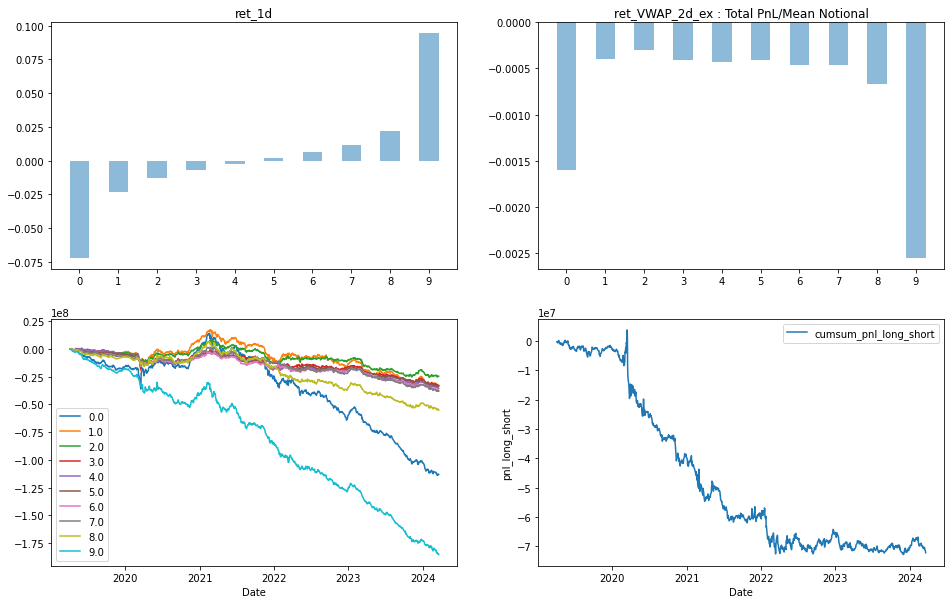

In [445]:
#Factor1
pct_analysis(sub_data_df, "ret_1d", 'notional', target_col)

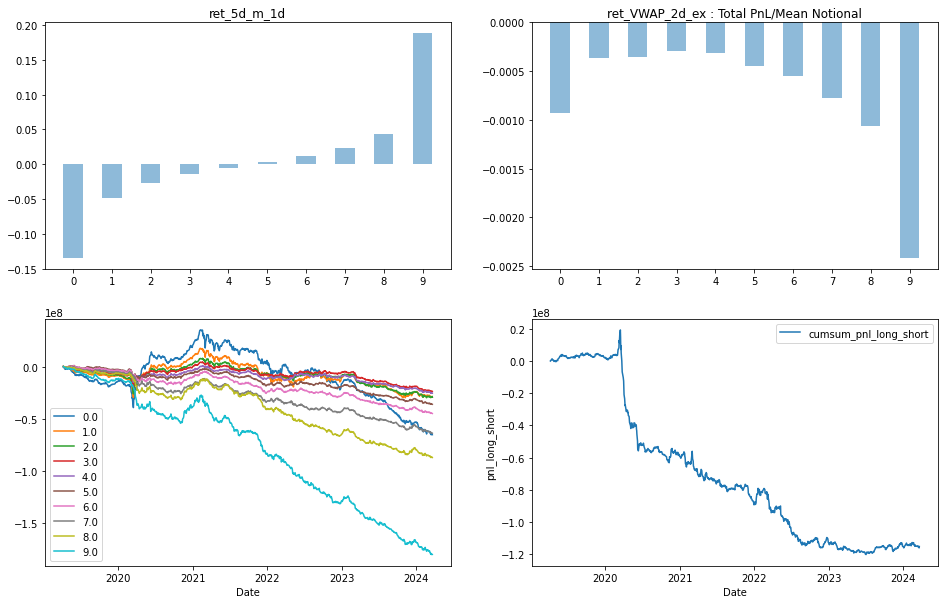

In [446]:
#Factor2
pct_analysis(sub_data_df, "ret_5d_m_1d", 'notional', target_col)

<h3> Momentum Factors </h3>

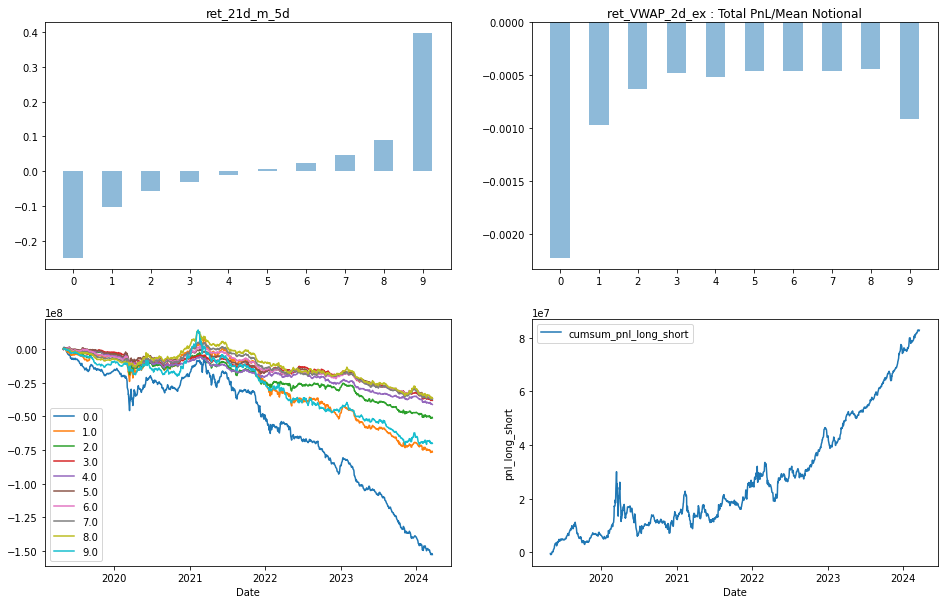

In [447]:
#Factor3
pct_analysis(sub_data_df, "ret_21d_m_5d", 'notional', target_col)

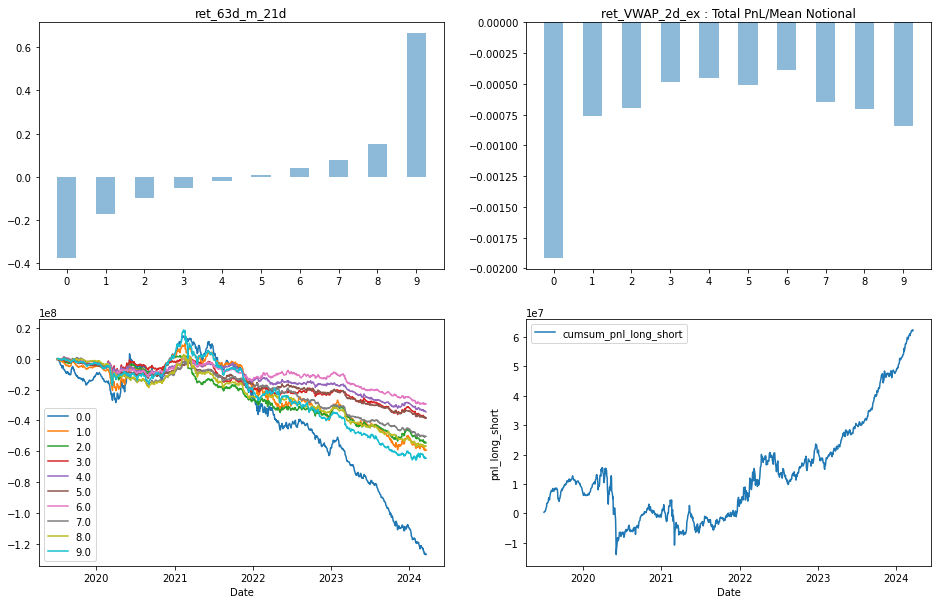

In [448]:
#Factor4
pct_analysis(sub_data_df, "ret_63d_m_21d", 'notional', target_col)

<h3> Combining Factors </h3>

In [491]:
bins = 10
factors = ['ret_1d','ret_5d_m_1d','ret_21d_m_5d',"ret_63d_m_21d"]
factor_types = ['reversion', 'reversion', 'momentum', 'momentum']

for idx, (factor_col, factor_type) in enumerate(zip(factors,factor_types)):

    graph_df = sub_data_df[["Date", factor_col, notional_col, target_col]].copy()
    graph_df['Date'] = pd.to_datetime(graph_df['Date'], utc=True).dt.date
    graph_df["factor"] = graph_df[factor_col].fillna(0.0)
    graph_df['bin'] = graph_df.groupby(["Date"])['factor'].transform( lambda x: pd.qcut(x, bins, labels=False, duplicates='drop' ) )

    #Reduce bins universe
    graph_df = graph_df[(graph_df['bin']==bins-1)|(graph_df['bin']==0)]

    #Get PnL
    graph_df["notional"] = graph_df[notional_col]
    graph_df["pnl"] = graph_df["notional"]*graph_df[target_col]
    bin_pnl_df = graph_df.groupby(['bin','Date'])[['pnl']].sum().sort_values(['bin','Date']).reset_index()

    #Filter each long short
    long = bin_pnl_df[bin_pnl_df['bin']==bins-1].rename(columns = {'pnl':'pnl_long'})
    short = bin_pnl_df[bin_pnl_df['bin']==0].rename(columns = {'pnl':'pnl_short'})

    #Get long short
    long_short = long.merge(short, how='outer', left_on='Date', right_on='Date')
    long_short["pnl_ls_"+factor_col] = long_short["pnl_long"] - long_short["pnl_short"]
    long_short = long_short[['Date','pnl_ls_'+factor_col]].sort_values('Date')
    
    #Factor Type
    if factor_type == 'reversion':
        long_short["pnl_ls_"+factor_col] *= -1
    
    if idx == 0:
        factor_pnl_df = long_short
    else:
        factor_pnl_df = factor_pnl_df.merge(long_short, how='outer', left_on='Date', right_on='Date')

In [633]:
factor_pnl_cols = ["pnl_ls_"+factor for factor in factors]
factor_pnl_yest_cols = ["pnl_ls_"+factor+"_yest" for factor in factors]
factor_pnl_weights_cols = ["weight_"+factor for factor in factors]

#METHOD1: notional balanced
factor_pnl_df["pnl_balanced_notional"] = np.average(factor_pnl_df[factor_pnl_cols], weights=[1/len(factors)]*4, axis=1)

In [634]:
#METHOD2: yesterday's pnl
for factor_pnl_col in factor_pnl_cols:
    factor_pnl_df[factor_pnl_col+"_yest"] = factor_pnl_df[factor_pnl_col].shift(1)

def get_yest_max_col(x):
    x = str(x)
    if '_yest' in x:
        x = x.replace('_yest',"")
    elif x == "nan":
        x = 'pnl_ls_ret_1d'
    return x

factor_pnl_df["yest_max_factor"] = factor_pnl_df[factor_pnl_yest_cols].idxmax(axis=1).apply( get_yest_max_col )
factor_pnl_df["pnl_yest_max"] = factor_pnl_df.apply( lambda x: x[x['yest_max_factor']], axis=1 )

In [635]:
#METHOD3: last week best proporational
def add_positive_pnl(row):
    total_pnl = 0
    
    # Only add positive pnl
    for col in factor_pnl_cols:
        positive_pnl = row[col] if row[col] > 0 else 0
        total_pnl += positive_pnl
    
    return total_pnl

weights_df = factor_pnl_df.rolling(5, closed='left')[factor_pnl_cols].mean()
weights_df['last_week_mean_positive_pnl'] = weights_df.apply( add_positive_pnl, axis=1 )

for factor in factors:
    weights_df['weight_'+factor] = np.where( weights_df['pnl_ls_'+factor] > 0,
                                             weights_df['pnl_ls_'+factor]/weights_df['last_week_mean_positive_pnl'],
                                             np.where(weights_df['last_week_mean_positive_pnl'] == 0, 1/len(factors), 0) )
    
    factor_pnl_df['weight_'+factor] = weights_df['weight_'+factor]

factor_pnl_df["pnl_last_week_proportional"] = np.average(factor_pnl_df[factor_pnl_cols], weights=factor_pnl_df[factor_pnl_weights_cols], axis=1)

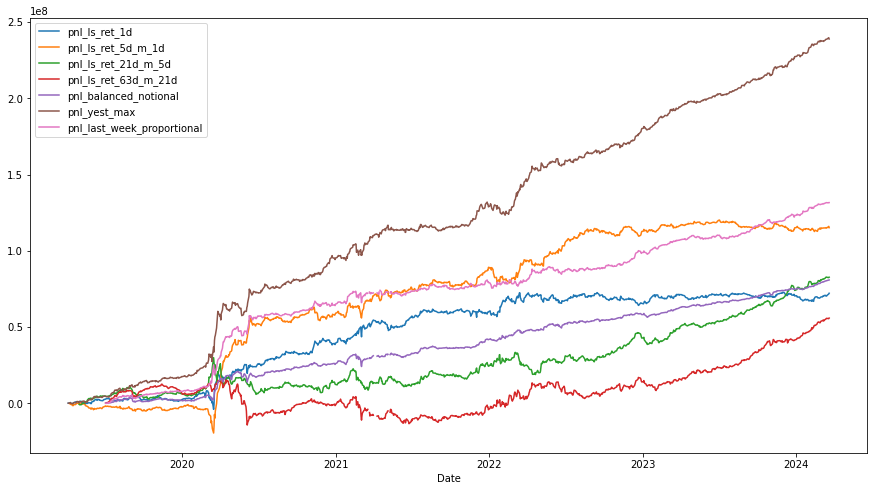

In [638]:
plt.figure(figsize=(15,8))

factor_pnl_df.set_index('Date').cumsum(axis=0)["pnl_ls_ret_1d"].plot()
factor_pnl_df.set_index('Date').cumsum(axis=0)["pnl_ls_ret_5d_m_1d"].plot()
factor_pnl_df.set_index('Date').cumsum(axis=0)["pnl_ls_ret_21d_m_5d"].plot()
factor_pnl_df.set_index('Date').cumsum(axis=0)["pnl_ls_ret_63d_m_21d"].plot()

factor_pnl_df.set_index('Date').cumsum(axis=0)["pnl_balanced_notional"].plot()
factor_pnl_df.set_index('Date').cumsum(axis=0)["pnl_yest_max"].plot()
factor_pnl_df.set_index('Date').cumsum(axis=0)["pnl_last_week_proportional"].plot()

plt.legend()

<h1> 2. EWM and RSI Strategy </h1>

<h3> Long-short portfolio construction based on EWM and RSI </h3>

In [433]:
factor_col = "rsi_14"
notional_col = "traded_value_1d"
target_col = "ret_VWAP_2d_ex"
ewm_window1 = 'ewm_100'
ewm_window2 = 'ewm_5'

# Everyday,
#  - long  : ewm < close and rsi low
#  - short : ewm > close and rsi hi

#Why percentile? RSI with longer window tends to have fewer RSI < 30 & RSI > 70
cols = ['T', 'Date', factor_col, notional_col, target_col]

#Short
position = 'short'
short_df = data_df[(data_df[ewm_window1]>data_df['c']) #down trend
                  &(abs(data_df[target_col])<0.50)][cols].copy()
short_df["notional"] = (short_df[notional_col] * 0.01).clip(upper=1e6)
short_plot = short_df[factor_col].copy()
short_threshold = short_df.groupby('Date')[factor_col].quantile(0.90).clip(lower=60)
short_df = short_df[short_df[factor_col] >= short_df['Date'].map(short_threshold)]
short_df = short_df.rename(columns={'notional': position+"_notional",
                                    factor_col: position+"_"+factor_col,
                                    target_col: position+'_'+target_col})

#Long
position = 'long'
long_df = data_df[(data_df[ewm_window1]<data_df['c']) #up trend
                 &(abs(data_df[target_col])<0.50)][cols].copy()
long_df["notional"] = (long_df[notional_col] * 0.01).clip(upper=1e6)
long_plot = long_df[factor_col].copy()
long_threshold = long_df.groupby('Date')[factor_col].quantile(0.10).clip(upper=40)
long_df = long_df[long_df[factor_col] <= long_df['Date'].map(long_threshold)]
long_df = long_df.rename(columns={'notional': position+"_notional",
                                  factor_col: position+"_"+factor_col,
                                  target_col: position+'_'+target_col})

<AxesSubplot:>

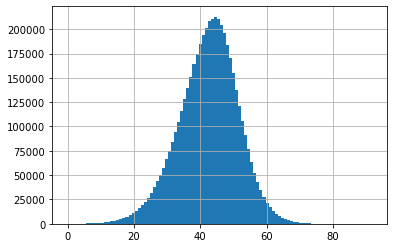

In [439]:
short_plot.hist(bins=100)

<AxesSubplot:>

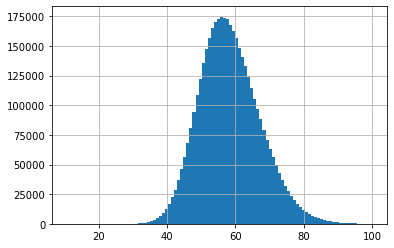

In [435]:
long_plot.hist(bins=100)

<h3> Long-short notional balanced portfolio </h3>

<ipython-input-436-47d31b132e5d>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


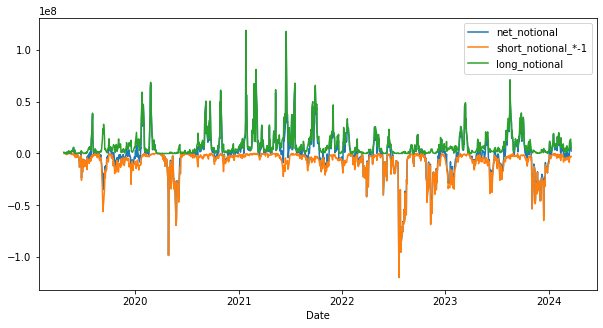

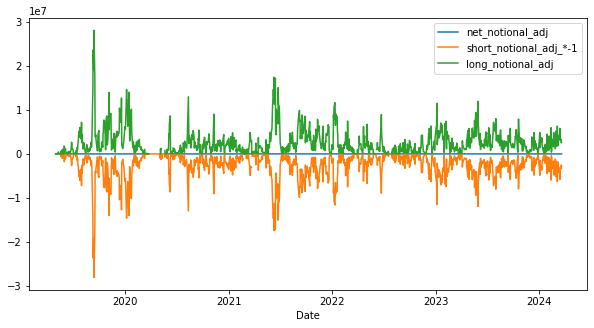

In [436]:
#Long-short notional balanced portfolio

long_short_df = long_df.merge(short_df, how='outer', left_on=['Date','T'], right_on=['Date','T'])

#Take daily min notional
daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()
daily_notional['min_notional'] = daily_notional[['long_notional','short_notional']].min(axis=1)

#Get long/short scalar
daily_notional['long_scaler'] = daily_notional['min_notional']/daily_notional['long_notional']
daily_notional['short_scaler'] = daily_notional['min_notional']/daily_notional['short_notional']

#Plot
daily_notional['long_notional_adj'] = daily_notional['long_notional']*daily_notional['long_scaler']
daily_notional['short_notional_adj'] = daily_notional['short_notional']*daily_notional['short_scaler']

daily_notional['short_notional_*-1'] = daily_notional['short_notional']*-1
daily_notional['short_notional_adj_*-1'] = daily_notional['short_notional_adj']*-1

daily_notional['net_notional'] = daily_notional['long_notional'] - daily_notional['short_notional']
daily_notional['net_notional_adj'] = daily_notional['long_notional_adj'] - daily_notional['long_notional_adj']

daily_notional[['net_notional', 'short_notional_*-1','long_notional']].plot(figsize=(10,5))
daily_notional[['net_notional_adj', 'short_notional_adj_*-1','long_notional_adj']].plot(figsize=(10,5))

#Adjust notional
daily_notional = daily_notional[['long_scaler','short_scaler']].reset_index()
long_short_df = long_short_df.merge(daily_notional, how='left', left_on='Date', right_on='Date')
long_short_df['long_notional_adj'] = long_short_df['long_notional']*long_short_df['long_scaler']
long_short_df['short_notional_adj'] = long_short_df['short_notional']*long_short_df['short_scaler']

<AxesSubplot:xlabel='Date'>

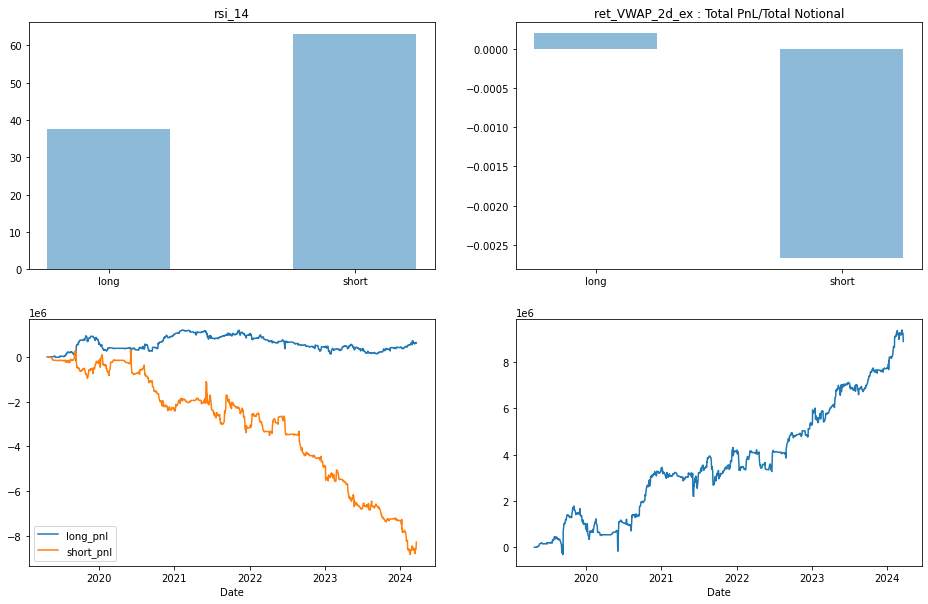

In [437]:
#PLOT
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

#1. histogram - factor
long_short_rsi_mean = long_short_df.groupby('Date')[['long_'+factor_col, 'short_'+factor_col]].mean().mean().values
ax1.set_title(factor_col)
ax1.bar(['long','short'], long_short_rsi_mean, width=0.5, alpha=0.5, align='center')

#2. histogram - target
long_short_df['long_pnl'] = long_short_df['long_notional_adj']*long_short_df["long_ret_VWAP_2d_ex"]
long_short_df['short_pnl'] = long_short_df['short_notional_adj']*long_short_df["short_ret_VWAP_2d_ex"]

long_pnl_by_notional = long_short_df['long_pnl'].sum()/long_short_df['long_notional_adj'].sum()
short_pnl_by_notional = long_short_df['short_pnl'].sum()/long_short_df['short_notional_adj'].sum()
long_short_pnl = [long_pnl_by_notional, short_pnl_by_notional]

ax2.set_title(target_col+" : Total PnL/Total Notional")
ax2.bar(['long','short'], long_short_pnl, width=0.5, alpha=0.5, align='center')

#3. long-short portfolio
pnl_df = long_short_df.groupby('Date')[['long_pnl', 'short_pnl']].sum()
pnl_df.cumsum(axis=0).plot(legend=True, ax=ax3)

#4. long-long portfolio
pnl_df["total_pnl"] =pnl_df["long_pnl"]-pnl_df["short_pnl"]
pnl_df["total_pnl"].cumsum(axis=0).plot(ax=ax4)

In [727]:
def get_rsi_long_short(data_df,factor_col, notional_col, target_col, ewm_window):
    
    # Everyday,
    #  - long  : ewm < close and rsi low
    #  - short : ewm > close and rsi hi

    #Why percentile? RSI with longer window tends to have fewer RSI < 30 & RSI > 70
    cols = ['T', 'Date', factor_col, notional_col, target_col]

    #Short
    position = 'short'
    short_df = data_df[(abs(data_df[target_col])<0.50)][cols].copy()
    short_df["notional"] = (short_df[notional_col] * 0.01).clip(upper=1e6)
    short_plot = short_df[factor_col].copy()
    short_threshold = short_df.groupby('Date')[factor_col].quantile(0.90).clip(lower=60) #Overbought - 10%
    short_df = short_df[short_df[factor_col] >= short_df['Date'].map(short_threshold)]
    short_df = short_df.rename(columns={'notional': position+"_notional",
                                        factor_col: position+"_"+factor_col,
                                        target_col: position+'_'+target_col})

    #Long
    position = 'long'
    long_df = data_df[(abs(data_df[target_col])<0.50)][cols].copy()
    long_df["notional"] = (long_df[notional_col] * 0.01).clip(upper=1e6)
    long_plot = long_df[factor_col].copy()
    long_threshold = long_df.groupby('Date')[factor_col].quantile(0.10).clip(upper=40) #Underbought - 10%
    long_df = long_df[long_df[factor_col] <= long_df['Date'].map(long_threshold)]
    long_df = long_df.rename(columns={'notional': position+"_notional",
                                      factor_col: position+"_"+factor_col,
                                      target_col: position+'_'+target_col})
    
    return (long_df,short_df)

In [689]:
def get_long_short_notional_balanced_pf(long_df, short_df, plot=False):    
    #Long-short notional balanced portfolio
    long_short_df = long_df.merge(short_df, how='outer', left_on=['Date','T'], right_on=['Date','T'])

    #Take daily min notional
    daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()
    daily_notional['min_notional'] = daily_notional[['long_notional','short_notional']].min(axis=1)

    #Get long/short scalar
    daily_notional['long_scaler'] = daily_notional['min_notional']/daily_notional['long_notional']
    daily_notional['short_scaler'] = daily_notional['min_notional']/daily_notional['short_notional']

    #Plot
    if plot:
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16, 5))
        
        daily_notional['long_notional_adj'] = daily_notional['long_notional']*daily_notional['long_scaler']
        daily_notional['short_notional_adj'] = daily_notional['short_notional']*daily_notional['short_scaler']

        daily_notional['short_notional_*-1'] = daily_notional['short_notional']*-1
        daily_notional['short_notional_adj_*-1'] = daily_notional['short_notional_adj']*-1

        daily_notional['net_notional'] = daily_notional['long_notional'] - daily_notional['short_notional']
        daily_notional['net_notional_adj'] = daily_notional['long_notional_adj'] - daily_notional['long_notional_adj']

        daily_notional[['net_notional', 'short_notional_*-1','long_notional']].plot(ax=ax1)
        ax1.set_title("Notional without balancing")
        daily_notional[['net_notional_adj', 'short_notional_adj_*-1','long_notional_adj']].plot(ax=ax2)
        ax2.set_title("Notional with balancing")

    #Adjust notional
    daily_notional = daily_notional[['long_scaler','short_scaler']].reset_index()
    long_short_df = long_short_df.merge(daily_notional, how='left', left_on='Date', right_on='Date')
    long_short_df['long_notional_adj'] = long_short_df['long_notional']*long_short_df['long_scaler']
    long_short_df['short_notional_adj'] = long_short_df['short_notional']*long_short_df['short_scaler']
    
    #Get Long/Short PnL
    long_short_df['long_pnl'] = long_short_df['long_notional_adj']*long_short_df["long_ret_VWAP_2d_ex"]
    long_short_df['short_pnl'] = long_short_df['short_notional_adj']*long_short_df["short_ret_VWAP_2d_ex"]

    return long_short_df

In [690]:
def pct_analysis_rsi(long_short_df):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))

    #1. histogram - factor
    long_short_rsi_mean = long_short_df.groupby('Date')[['long_'+factor_col, 'short_'+factor_col]].mean().mean().values
    ax1.set_title(factor_col)
    ax1.bar(['long','short'], long_short_rsi_mean, width=0.5, alpha=0.5, align='center')

    #2. histogram - target
    long_pnl_by_notional = long_short_df['long_pnl'].sum()/long_short_df['long_notional_adj'].sum()
    short_pnl_by_notional = long_short_df['short_pnl'].sum()/long_short_df['short_notional_adj'].sum()
    long_short_pnl = [long_pnl_by_notional, short_pnl_by_notional]

    ax2.set_title(target_col+" : Total PnL/Total Notional")
    ax2.bar(['long','short'], long_short_pnl, width=0.5, alpha=0.5, align='center')

    #3. long-short portfolio
    pnl_df = long_short_df.groupby('Date')[['long_pnl', 'short_pnl']].sum()
    pnl_df.cumsum(axis=0).plot(legend=True, ax=ax3)

    #4. long-long portfolio
    pnl_df["total_pnl"] =pnl_df["long_pnl"]-pnl_df["short_pnl"]
    pnl_df["total_pnl"].cumsum(axis=0).plot(ax=ax4)

<h3> Long-short strategy performance </h3>

<ipython-input-689-c61ed96a5472>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


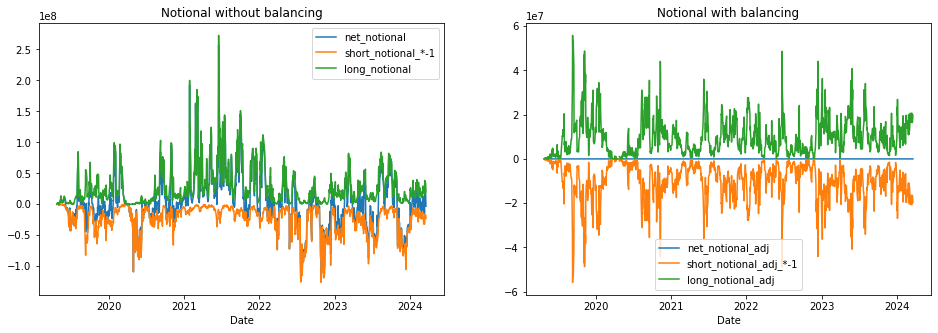

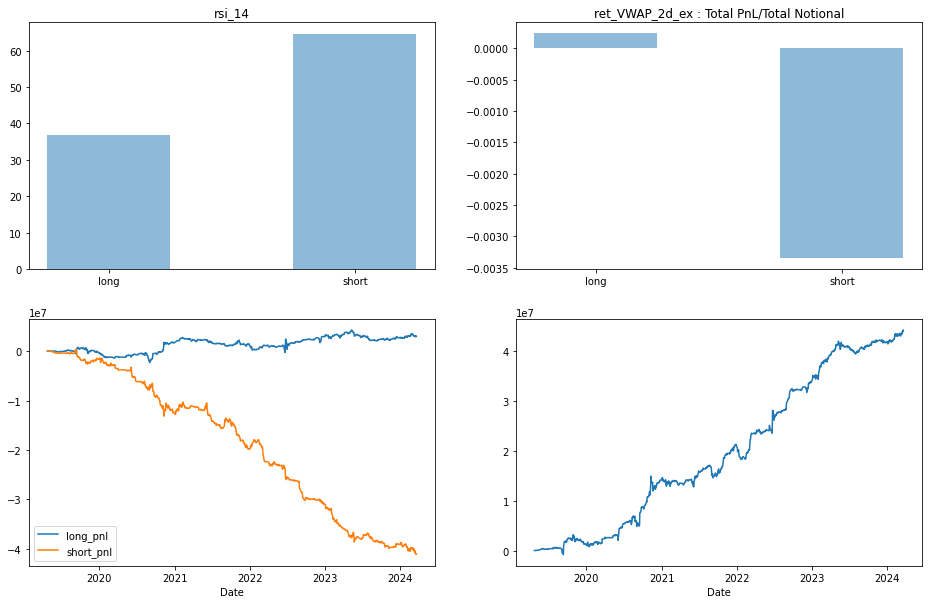

In [691]:
factor_col = "rsi_2"
notional_col = "traded_value_1d"
target_col = "ret_VWAP_2d_ex"
ewm_window = 'ewm_200'

long_df, short_df = get_rsi_long_short(data_df,factor_col, notional_col, target_col, ewm_window)
long_short_df = get_long_short_notional_balanced_pf(long_df, short_df, plot=True)
pct_analysis_rsi(long_short_df)

<h3> Finding best parameters </h3>

rsi_2/ewm_5....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


rsi_5/ewm_5....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


rsi_14/ewm_5....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


rsi_2/ewm_20....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


rsi_5/ewm_20....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


rsi_14/ewm_20....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


rsi_2/ewm_100....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


rsi_5/ewm_100....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


rsi_14/ewm_100....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


rsi_2/ewm_200....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


rsi_5/ewm_200....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()
/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


rsi_14/ewm_200....



<ipython-input-670-0f2c82613679>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


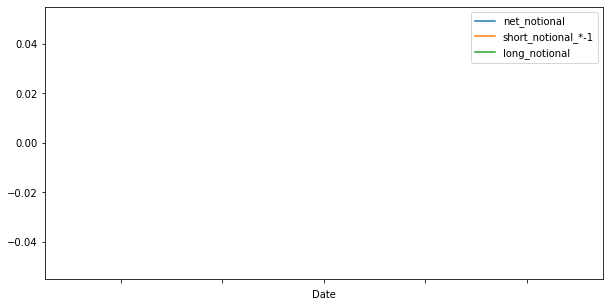

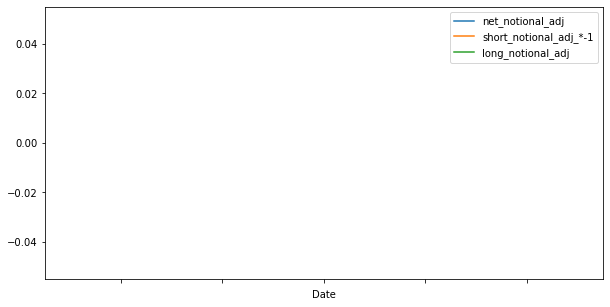

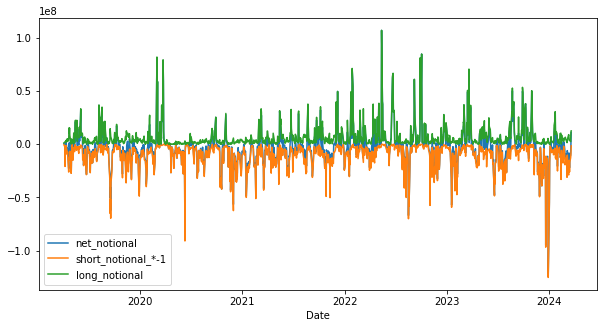

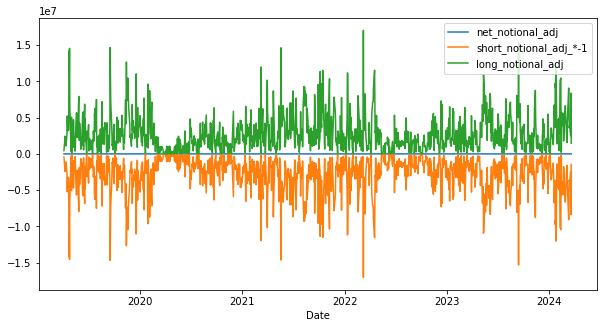

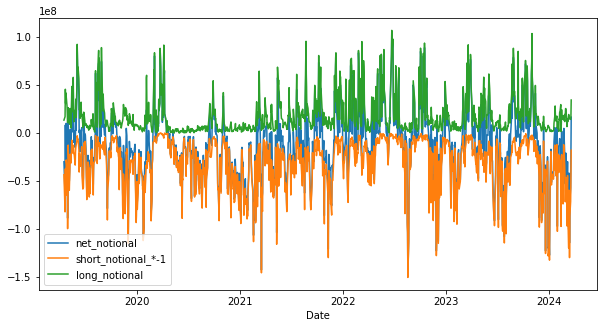

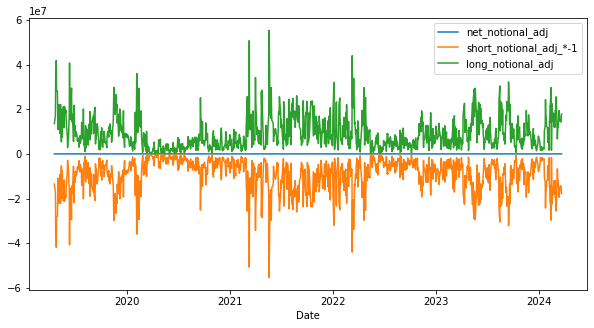

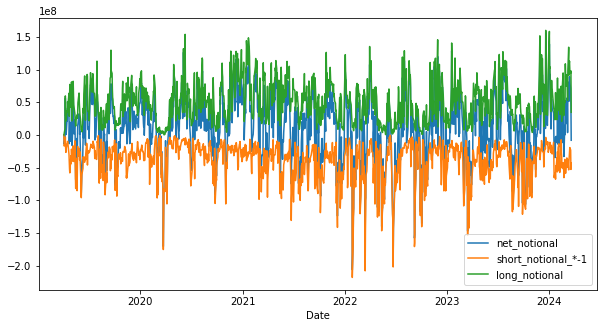

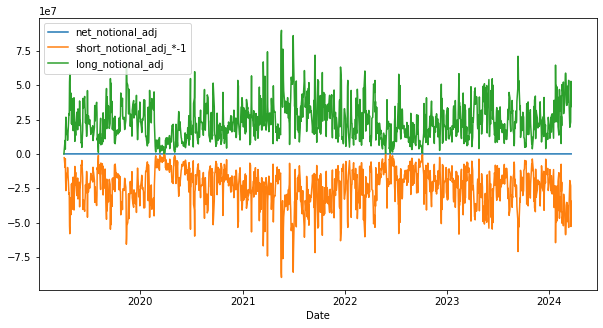

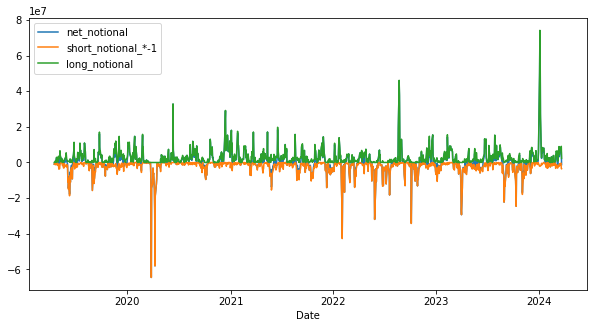

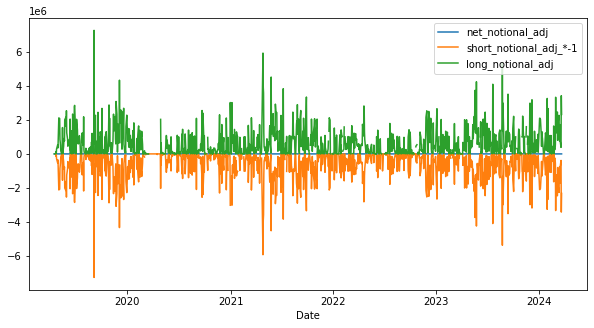

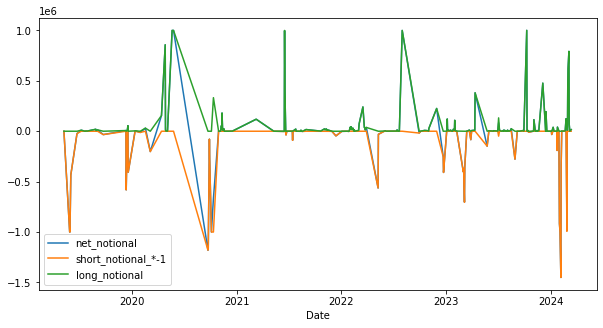

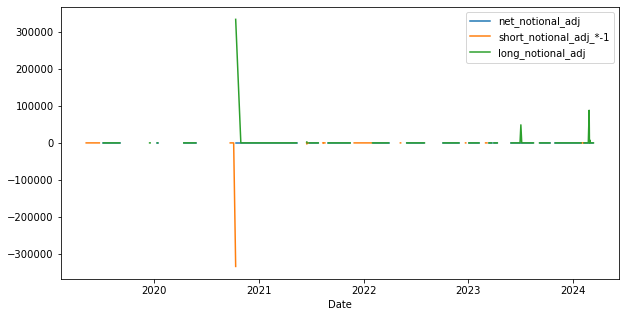

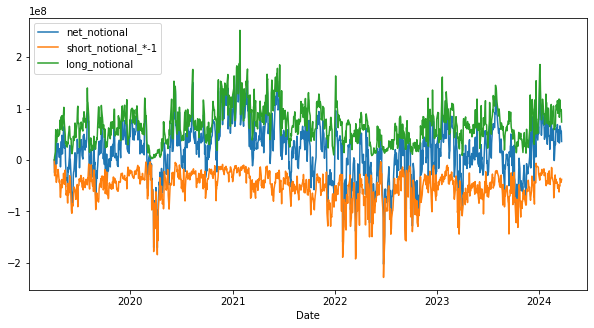

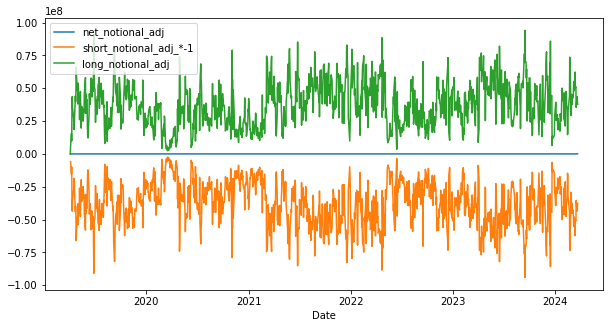

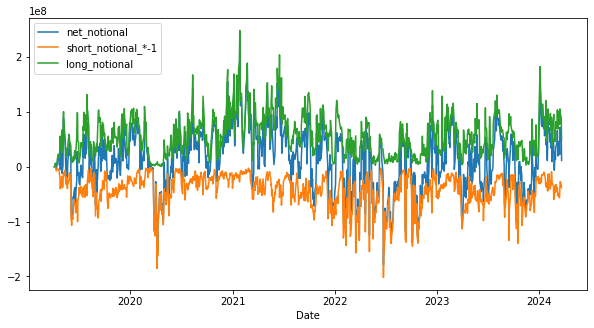

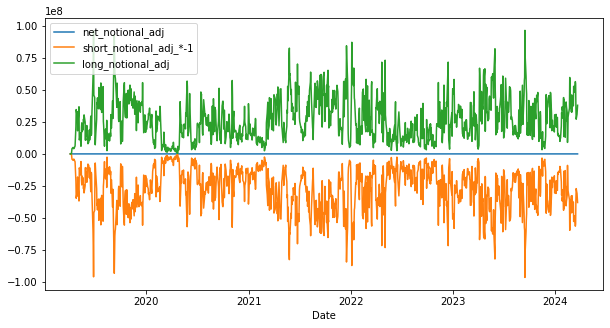

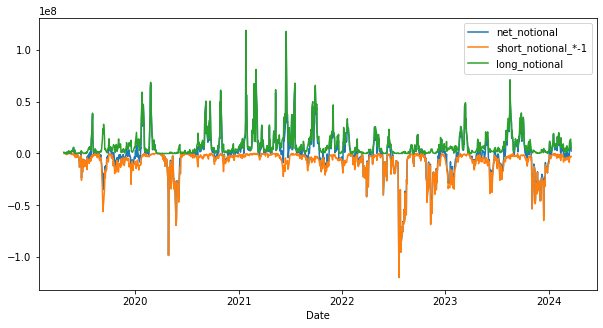

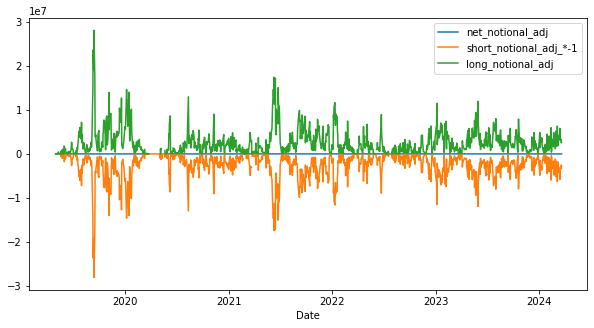

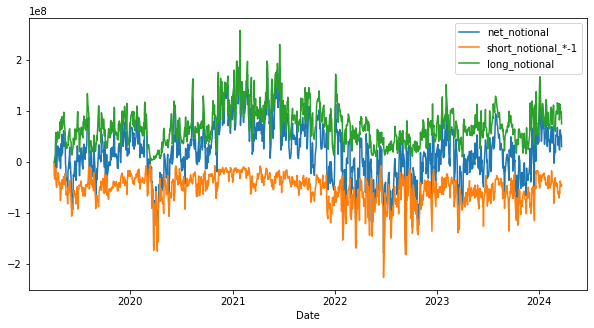

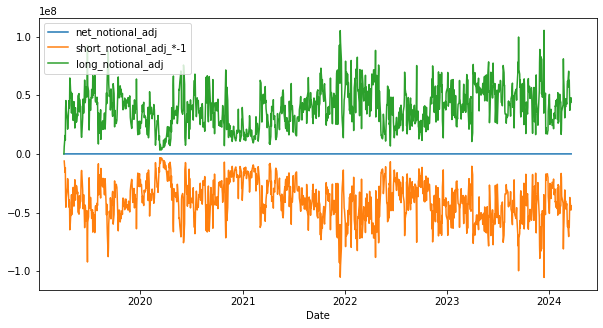

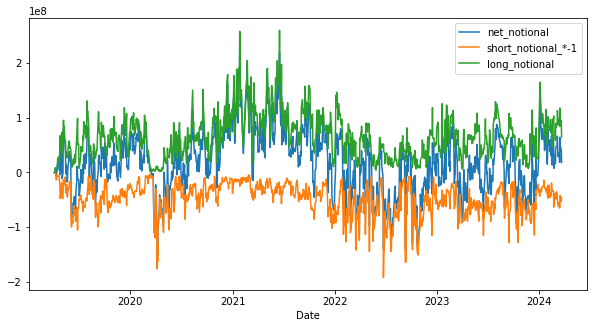

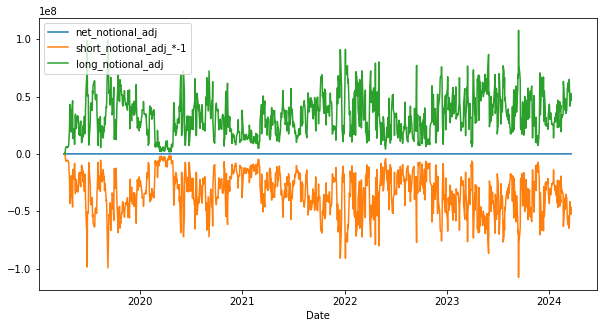

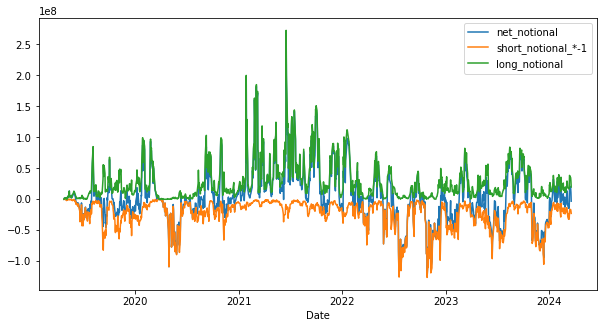

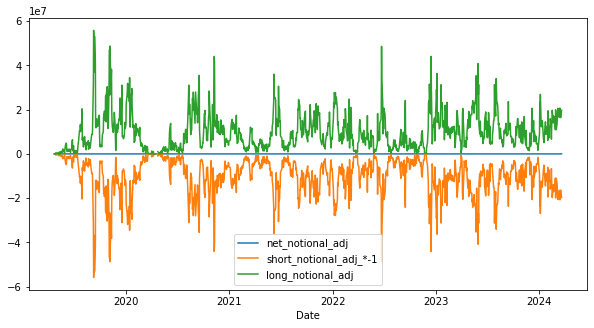

In [681]:
rsi_windows = ['rsi_2', 'rsi_5', 'rsi_14']
ewm_windows = ['ewm_5','ewm_20','ewm_100','ewm_200']

notional_col = "traded_value_1d"
target_col = "ret_VWAP_2d_ex"

d = dict()
for ewm_window in ewm_windows:
    for rsi_window in rsi_windows:
        key = rsi_window+"/"+ewm_window
        print(key+"....\n")
        
        factor_col = rsi_window
        
        long_df, short_df = get_rsi_long_short(data_df, factor_col, notional_col, target_col, ewm_window)
        long_short_df = get_long_short_notional_balanced_pf(long_df, short_df, plot=True)
        
        pnl_df = long_short_df.groupby('Date')[['long_pnl', 'short_pnl']].sum()
        pnl_df["total_pnl"] =pnl_df["long_pnl"]-pnl_df["short_pnl"]
        
        d[key] = pnl_df


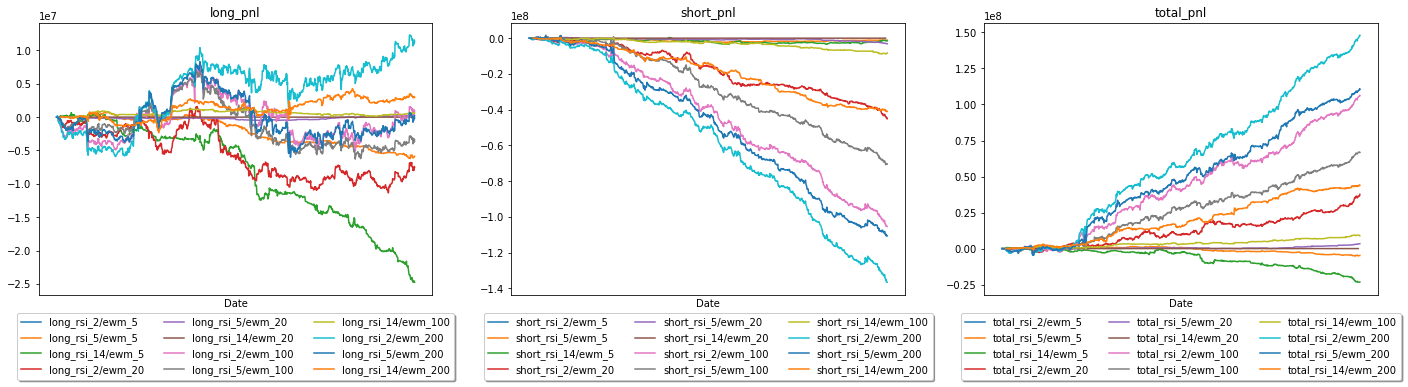

In [723]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(24, 5))

for ewm_window in ewm_windows:
    for rsi_window in rsi_windows:
        key = rsi_window+"/"+ewm_window
        
        pnl_df = d[key]
        pnl_df = pnl_df.rename(columns={"long_pnl":"long_"+key,"short_pnl":"short_"+key,"total_pnl":"total_"+key})
        pnl_df["long_"+key].cumsum(axis=0).plot(ax=ax1)
        pnl_df["short_"+key].cumsum(axis=0).plot(ax=ax2)
        pnl_df["total_"+key].cumsum(axis=0).plot(ax=ax3)
        
ax1.set_title("long_pnl")
ax2.set_title("short_pnl")
ax3.set_title("total_pnl")

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)
ax3.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)

<h3> Best parameter example </h3>

<ipython-input-689-c61ed96a5472>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  daily_notional = long_short_df.groupby('Date')['long_notional','short_notional'].sum()


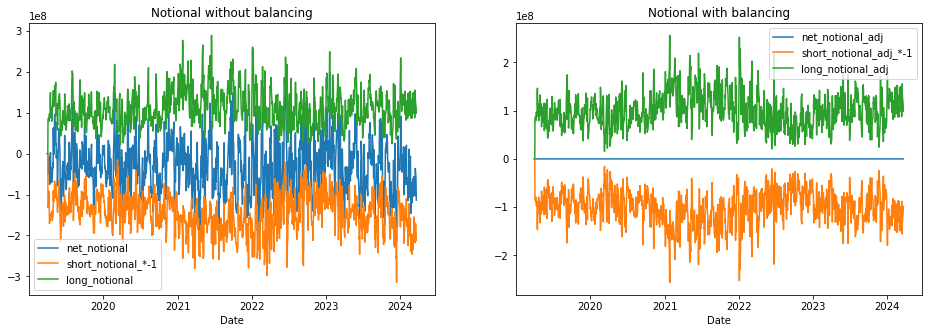

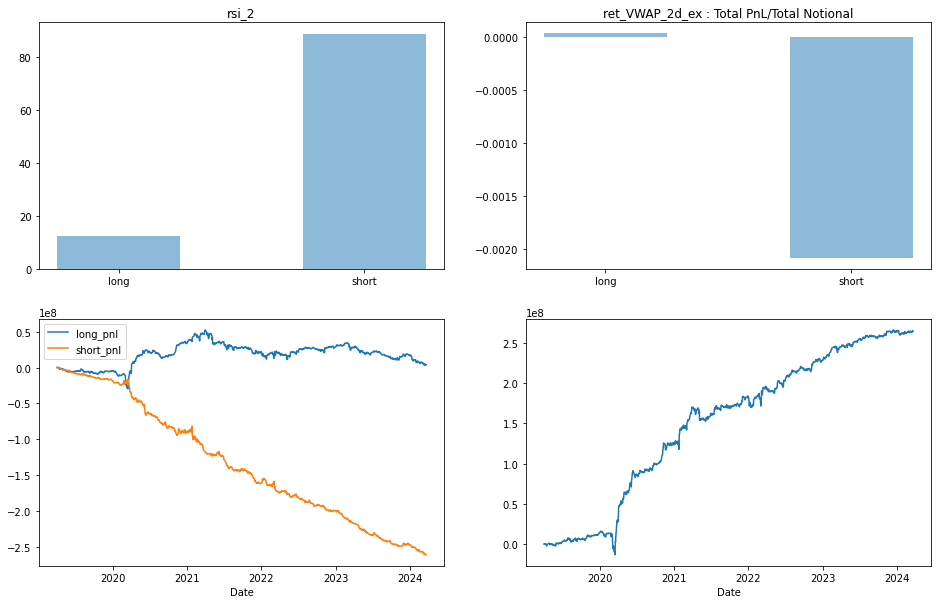

In [728]:
factor_col = "rsi_2"
notional_col = "traded_value_1d"
target_col = "ret_VWAP_2d_ex"
ewm_window = 'ewm_200'

long_df, short_df = get_rsi_long_short(data_df,factor_col, notional_col, target_col, ewm_window)
long_short_df = get_long_short_notional_balanced_pf(long_df, short_df, plot=True)
pct_analysis_rsi(long_short_df)